# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Xinghe Pan

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2023-12-15 20:41:57.703180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 20:41:57.873915: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 20:41:57.879125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-15 20:41:57.879152: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

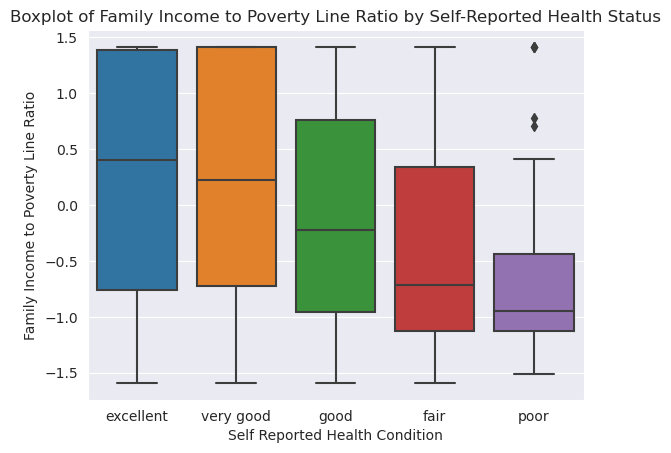

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

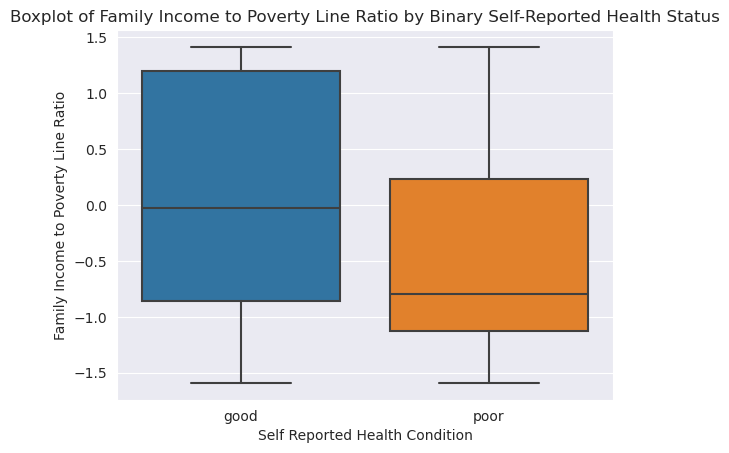

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

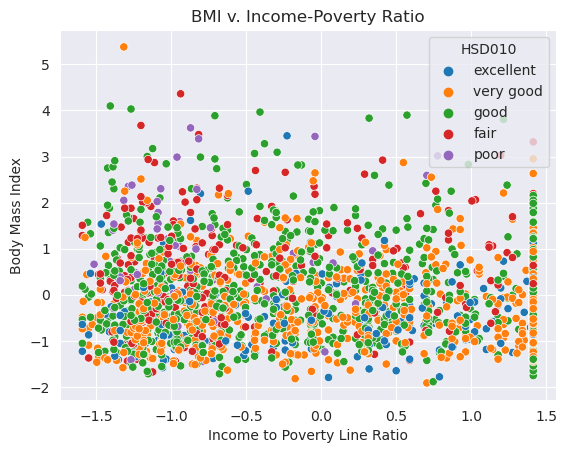

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled_copy = nhanes_scaled
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

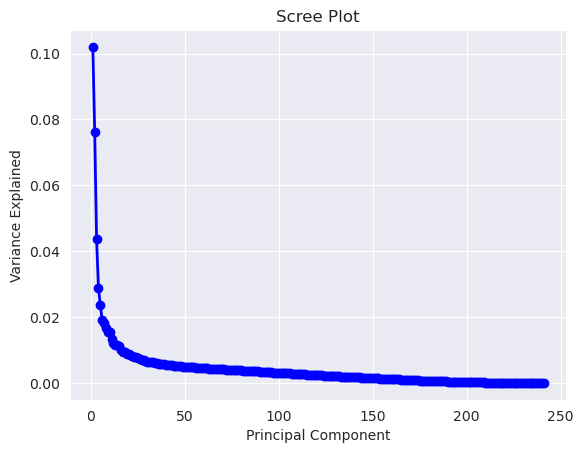

In [7]:
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------
from sklearn.decomposition import PCA
# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Using the elbow method, there seems to be a significant change in the slope in the Scree plot between the 6th and 7th components. So 6 components are kept.

In [8]:
# keep 6 components
# apply PCA
# ----------
pca = PCA(n_components=6)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

### Barplot of Components

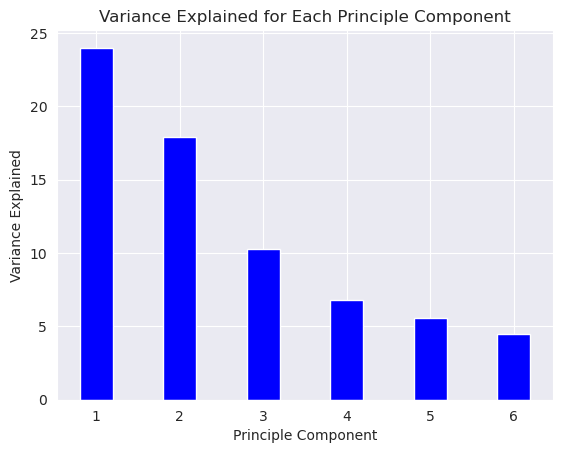

In [9]:
# creating the bar plot
components = [1,2,3,4,5,6]

plt.bar(components, pca.explained_variance_, color ='blue', 
        width = 0.4)
 
plt.xlabel("Principle Component")
plt.ylabel("Variance Explained")
plt.title("Variance Explained for Each Principle Component")
plt.show()

### How many components will you use to fit a supervised learning model?

I will keep 5 components for fitting a supervised learning model because the first five components each explain significant (> 5%) percentages of the variance in the data. Keeping 5 components is also acceptable in terms of balancing overfitting and underfitting. 

In [13]:
# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3',
                                 'principal component 4',
                                 'principal component 5',
                                 'principal component 6'])
pca_df_copy = pca_df.copy()

In [14]:
pca_df_copy

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6
0,9.527811,-0.816223,-1.867048,-2.110456,-3.929426,-0.193860
1,-5.838338,-3.692572,3.805803,-1.029993,0.394876,1.578702
2,-0.719454,-2.573200,0.907912,-4.755686,-1.797068,0.846995
3,3.533627,-2.576982,-3.249091,-0.405366,3.997325,1.437826
4,-6.872094,-4.194241,0.886818,-0.848856,-0.522795,0.061566
...,...,...,...,...,...,...
2059,2.643319,-1.689357,-0.702629,-0.537904,-1.020127,-0.680378
2060,1.037906,-0.118065,5.556480,1.630276,0.970390,1.125677
2061,1.130253,-0.970434,3.415276,1.207570,-3.630555,1.131001
2062,7.145093,-0.376751,1.753581,-0.939199,-4.668654,3.838900


In [15]:
nhanes_scaled_copy = nhanes_scaled_copy.reset_index(drop=True)
nhanes_scaled_copy

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary
0,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,good
1,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,good
2,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,good
3,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,good
4,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,0.0,0.261930,0.0,0.324834,-0.481375,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,0.480384,1.087115,-0.683338,0.612440,good,good
2060,0.0,0.495138,0.0,0.324834,1.093063,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,0.246091,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,very good,good
2061,0.0,0.728346,0.0,-3.078499,0.305844,-0.268620,-0.194202,-0.057306,0.128246,0.080373,...,2.031441,2.065262,1.125008,0.0,0.480384,-0.919866,-0.683338,-1.632812,fair,poor
2062,0.0,-0.857470,0.0,0.324834,-0.306437,0.182871,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,-0.484200,1.125008,0.0,0.480384,1.087115,-0.683338,-1.632812,excellent,good


<Figure size 640x480 with 0 Axes>

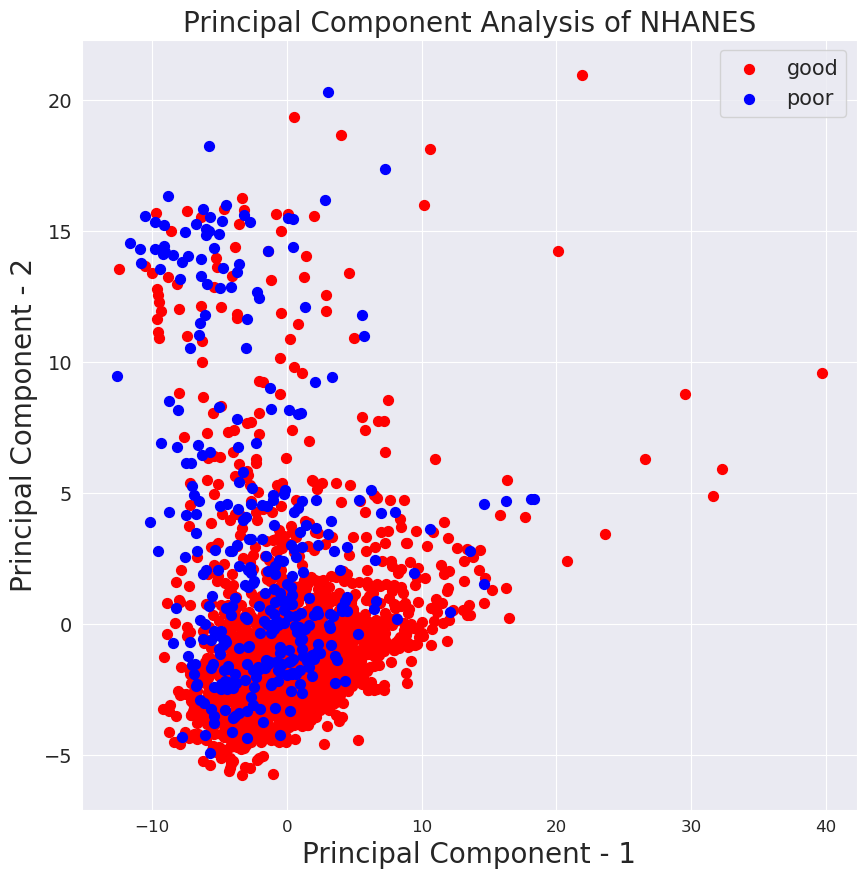

In [16]:
# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'b']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaled_copy['HSD010_binary'] == target
    #print(indicesToKeep[83704])
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

From the plot above, it seems that neither components correlate with binarized self-reported health condition.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I choose k-means clustering, which first randomly create k points in the data space as cluster centers and assign each data point to the cluster whose central point is the closest in Euclidean distance. Once all points are assigned, new central points are calculated and the process is repeated. 

In [17]:
kmeans = KMeans(n_clusters=6,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

For the NHANES data, I chose k = 6 using the elbow method (same Scree plot as above).

### Cluster nhanes

In [18]:
# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(nhanes_scaled, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.         -0.02661096  0.         ... -0.03480013 -0.02998168
  -0.09878856]
 [ 0.          0.0396747   0.         ... -0.02438357 -0.0909884
   0.23896402]
 [ 0.         -0.1349905   0.         ...  0.30439209  0.28269604
   0.61244043]
 [ 0.         -0.00275921  0.         ...  0.04333109  0.07602589
  -0.59819274]
 [ 0.          0.03354667  0.         ...  0.16766034  0.40589579
   0.61244043]
 [ 0.         -0.01388209  0.         ... -0.12203814 -0.1750987
   0.03724328]]

Labels
[0 3 5 ... 3 0 5]

Coordinates: DR1DRSTZ Label: 0
Coordinates: DR1EXMER Label: 3
Coordinates: DRABF Label: 5
Coordinates: DRDINT Label: 1
Coordinates: DR1DBIH Label: 5
Coordinates: DR1DAY Label: 1
Coordinates: DR1LANG Label: 5
Coordinates: DR1MNRSP Label: 4
Coordinates: DR1HELPD Label: 5
Coordinates: DBQ095Z Label: 1
Coordinates: DRQSPREP Label: 4
Coordinates: DR1STY Label: 3
Coordinates: DRQSDIET Label: 1
Coordinates: DR1TNUMF Label: 3
Coordinates: DR1TKCAL Label: 5
Coordinates: DR1TPROT Label

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [19]:
kmeans_df = pd.DataFrame(kmeans.labels_)
#kmeans_pca_df.value_counts()
nhanes_scaled_copy["cluster"] = kmeans_df
conditions = [nhanes_scaled_copy["cluster"] == 0, 
              nhanes_scaled_copy["cluster"] == 1, 
              nhanes_scaled_copy["cluster"] == 2, 
              nhanes_scaled_copy["cluster"] == 3, 
              nhanes_scaled_copy["cluster"] == 4, 
              nhanes_scaled_copy["cluster"] == 5]
choices = ["o", "^", "s", "P", "*", "D"]
nhanes_scaled_copy["marker"] = np.select(conditions, choices, default='black')
nhanes_scaled_copy

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,HSD010_binary,cluster,marker
0,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,excellent,good,0,o
1,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,excellent,good,3,P
2,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,very good,good,5,D
3,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,very good,good,1,^
4,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,good,5,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,0.0,0.261930,0.0,0.324834,-0.481375,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,1.125008,0.0,0.480384,1.087115,-0.683338,0.612440,good,good,1,^
2060,0.0,0.495138,0.0,0.324834,1.093063,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,very good,good,3,P
2061,0.0,0.728346,0.0,-3.078499,0.305844,-0.268620,-0.194202,-0.057306,0.128246,0.080373,...,1.125008,0.0,0.480384,-0.919866,-0.683338,-1.632812,fair,poor,3,P
2062,0.0,-0.857470,0.0,0.324834,-0.306437,0.182871,-0.194202,-0.057306,0.128246,-0.189513,...,1.125008,0.0,0.480384,1.087115,-0.683338,-1.632812,excellent,good,0,o


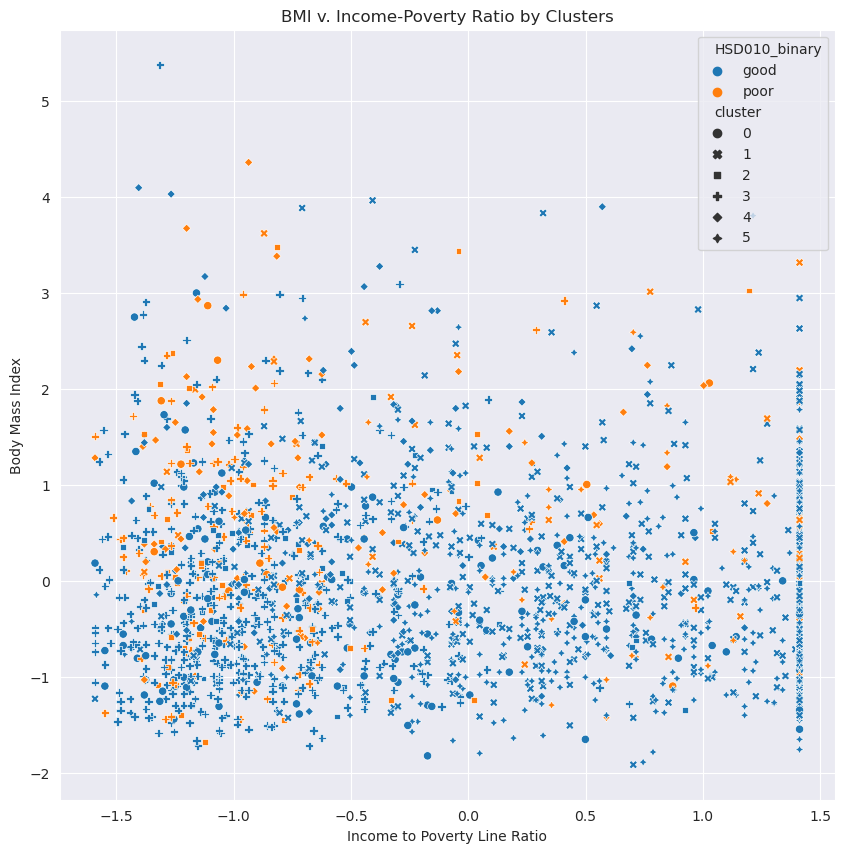

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010_binary", 
                     palette = "tab10", style = "cluster", data = nhanes_scaled_copy)
#plt.scatter(*kmeans.cluster_centers_.T, marker='+', c='black', label='cluster centers')

ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio by Clusters")
plt.show()

Given the large number of points and clusters, it is difficult to find any pattern in terms of the clusters in the space of BMI and Income to Poverty Line Ratio.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [21]:
kmeans_pca = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

In [22]:
kmeans_pca_df = pd.DataFrame(kmeans_pca.labels_)
#kmeans_pca_df.value_counts()

In [23]:
#pca_df_copy = pca_df
pca_df["cluster"] = kmeans_pca_df
pca_df["HSD010_binary"] = nhanes_scaled_copy["HSD010_binary"]

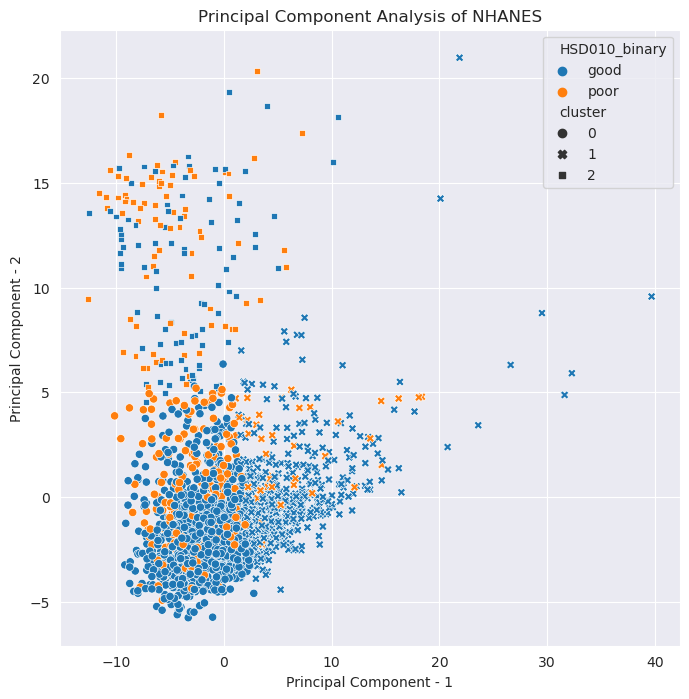

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "HSD010_binary", 
                     palette = "tab10", style = "cluster", data = pca_df)
#plt.scatter(*kmeans.cluster_centers_.T, marker='+', c='black', label='cluster centers')

ax.set(xlabel = 'Principal Component - 1',
      ylabel = 'Principal Component - 2')
ax.set_title("Principal Component Analysis of NHANES")
plt.show()

Cluster 0 seems to occupy the bottom-left part of the space, meaning small values along both components 1 and 2. Cluster 1 seems to occupy the right part of the space, meaning medium to large values along both components 1 and 2. Cluster 2 seems to occupy the top-left part of the space, meaning large values along component 2 and small values along component 1. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [26]:
# partition data
# -----------
y = nhanes_scaled_copy["HSD010_binary"] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
y = y.map({"good":1,"poor":0})

X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [27]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [28]:
# create neural network model
# -----------
num_nuerons = X_train.shape[1]
model = Sequential()

model.add(Dense(num_nuerons, input_dim= num_nuerons, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=2)

2023-12-15 21:10:37.472728: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-15 21:10:37.472770: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-15 21:10:37.472800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-xinghe-5fpan): /proc/driver/nvidia/version does not exist
2023-12-15 21:10:37.473236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
8/8 - 1s - loss: 0.5533 - accuracy: 0.7235 - val_loss: 0.3949 - val_accuracy: 0.8430 - 877ms/epoch - 110ms/step
Epoch 2/30
8/8 - 0s - loss: 0.3462 - accuracy: 0.8630 - val_loss: 0.3656 - val_accuracy: 0.8469 - 60ms/epoch - 8ms/step
Epoch 3/30
8/8 - 0s - loss: 0.3082 - accuracy: 0.8766 - val_loss: 0.3576 - val_accuracy: 0.8508 - 55ms/epoch - 7ms/step
Epoch 4/30
8/8 - 0s - loss: 0.2759 - accuracy: 0.8915 - val_loss: 0.3509 - val_accuracy: 0.8702 - 55ms/epoch - 7ms/step
Epoch 5/30
8/8 - 0s - loss: 0.2478 - accuracy: 0.9076 - val_loss: 0.3455 - val_accuracy: 0.8721 - 56ms/epoch - 7ms/step
Epoch 6/30
8/8 - 0s - loss: 0.2235 - accuracy: 0.9173 - val_loss: 0.3408 - val_accuracy: 0.8585 - 55ms/epoch - 7ms/step
Epoch 7/30
8/8 - 0s - loss: 0.2029 - accuracy: 0.9212 - val_loss: 0.3440 - val_accuracy: 0.8566 - 57ms/epoch - 7ms/step
Epoch 8/30
8/8 - 0s - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.3429 - val_accuracy: 0.8605 - 55ms/epoch - 7ms/step
Epoch 9/30
8/8 - 0s - loss: 0.1676 - 

### Neural Network on Principal Components

In [29]:
X = pca_df_copy # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [30]:
# create neural network model
# -----------
num_nuerons = X_train.shape[1]
model = Sequential()

model.add(Dense(num_nuerons, input_dim= num_nuerons, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=2)

Epoch 1/30
8/8 - 1s - loss: 0.6803 - accuracy: 0.7726 - val_loss: 0.6726 - val_accuracy: 0.8411 - 663ms/epoch - 83ms/step
Epoch 2/30
8/8 - 0s - loss: 0.6656 - accuracy: 0.8359 - val_loss: 0.6576 - val_accuracy: 0.8469 - 43ms/epoch - 5ms/step
Epoch 3/30
8/8 - 0s - loss: 0.6502 - accuracy: 0.8353 - val_loss: 0.6416 - val_accuracy: 0.8488 - 44ms/epoch - 6ms/step
Epoch 4/30
8/8 - 0s - loss: 0.6335 - accuracy: 0.8359 - val_loss: 0.6244 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 5/30
8/8 - 0s - loss: 0.6155 - accuracy: 0.8359 - val_loss: 0.6061 - val_accuracy: 0.8488 - 43ms/epoch - 5ms/step
Epoch 6/30
8/8 - 0s - loss: 0.5966 - accuracy: 0.8359 - val_loss: 0.5869 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 7/30
8/8 - 0s - loss: 0.5768 - accuracy: 0.8359 - val_loss: 0.5674 - val_accuracy: 0.8488 - 44ms/epoch - 6ms/step
Epoch 8/30
8/8 - 0s - loss: 0.5571 - accuracy: 0.8359 - val_loss: 0.5478 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 9/30
8/8 - 0s - loss: 0.5371 - a

### Neural Network on Principal Components + Cluster Membership

In [31]:
pca_df = pca_df.drop(["HSD010_binary"], axis = 1)

In [32]:
X = pca_df # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [33]:
# create neural network model
# -----------
num_nuerons = X_train.shape[1]
model = Sequential()

model.add(Dense(num_nuerons, input_dim= num_nuerons, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=200, verbose=2)

Epoch 1/30
8/8 - 1s - loss: 0.6911 - accuracy: 0.6008 - val_loss: 0.6826 - val_accuracy: 0.8198 - 631ms/epoch - 79ms/step
Epoch 2/30
8/8 - 0s - loss: 0.6773 - accuracy: 0.8288 - val_loss: 0.6678 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 3/30
8/8 - 0s - loss: 0.6626 - accuracy: 0.8359 - val_loss: 0.6522 - val_accuracy: 0.8488 - 43ms/epoch - 5ms/step
Epoch 4/30
8/8 - 0s - loss: 0.6469 - accuracy: 0.8359 - val_loss: 0.6351 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 5/30
8/8 - 0s - loss: 0.6293 - accuracy: 0.8359 - val_loss: 0.6168 - val_accuracy: 0.8488 - 54ms/epoch - 7ms/step
Epoch 6/30
8/8 - 0s - loss: 0.6104 - accuracy: 0.8359 - val_loss: 0.5971 - val_accuracy: 0.8488 - 44ms/epoch - 6ms/step
Epoch 7/30
8/8 - 0s - loss: 0.5906 - accuracy: 0.8359 - val_loss: 0.5762 - val_accuracy: 0.8488 - 43ms/epoch - 5ms/step
Epoch 8/30
8/8 - 0s - loss: 0.5693 - accuracy: 0.8359 - val_loss: 0.5549 - val_accuracy: 0.8488 - 41ms/epoch - 5ms/step
Epoch 9/30
8/8 - 0s - loss: 0.5478 - a

I would fit the neural network using the original features, because it has the highest accuracy among the three featurizations when epoch = 30. 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA seeks to reduce the dimensionality of a dataset with a large number of variables in a way that maximize the variation in the data. Its result is a set of new variables that are results of linear combinations of the original ones. Clustering seeks to group data points into clusters based on some measure of similarity (distance in the data space). It retains all the original variables.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

K-means clustering algorithm performs better with fewer number of variables (lower dimension), so performing PCA before clustering increases cluster quality. With NHANES data, it seems that clustering on the PCA result makes the clusters much easier to represent visually and seem more interpretable. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Performing PCA and clustering during preprocessing can give researchers insights about the data structure and detect preliminary patterns in the data, which helps researchers to formulate their research question and specify parameters in downstream supervised models. Also, dimensionality reduction with PCA can reduce the computational intensity and increase model interpretability of downstream supervised models.